# NLP with Disaster Tweets

# I. Import libraries

In [ ]:
# Import libraries

import numpy as np 
import pandas as pd 
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU, LSTM, Dense, Embedding
from tensorflow.keras import Sequential

# II. Load & Explore Dataset

In [ ]:
# Load train & test data
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")

# display train_df & test_df
print("train_df : ")
display(train_df)
print("test_df : ")
display(test_df)

train_df : 


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


test_df : 


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
# print the first three tweets where target is 0 (is not a disaster tweet)
print("Not disaster tweet :",train_df[train_df["target"] == 0]["text"].values[0:3])

print()

# print the first two tweets where target is 1 (is not a disaster tweet)
print("Disaster tweet :",train_df[train_df["target"] == 1]["text"].values[0:2])

Not disaster tweet : ["What's up man?" 'I love fruits' 'Summer is lovely']

Disaster tweet : ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada']


In [ ]:
# Keep only text and target on train dataset
train_df = train_df[["text","target"]]
display(train_df.head())
print("Train data shape : ", train_df.shape)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


Train data shape :  (7613, 2)


In [ ]:
# Keep only text on test dataset
test_df = test_df[["text"]]
display(test_df.head())
print("Test data shape : ", test_df.shape)

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


Test data shape :  (3263, 1)


In [ ]:
# Verify Missing values on train
train_df.isnull().any()

text      False
target    False
dtype: bool

In [ ]:
# proportion of each target on train
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# III. NLP with spacy 

In [ ]:
# Install spacy package for english langage
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
# Import English using en_core_web_sm.load()
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
# Import english stop words
from spacy.lang.en.stop_words import STOP_WORDS

# Print stop words
print(STOP_WORDS)

{'how', 'them', 'with', 'whereas', 'see', 'off', 'if', '‘ve', 'get', 'mostly', 'therein', 'whole', 'anything', 'too', 'hence', 'doing', 'any', 'hundred', 'n‘t', 'below', 'i', 'using', '’ve', 'amount', '’d', 'put', 'is', 'four', 'whose', 'never', 'front', 'thereupon', 'seeming', '’m', 'ever', 'will', 'least', 'thru', 'throughout', 'also', 'eight', 'nowhere', 'beforehand', 'might', 'thereafter', 'did', 'were', 'seems', 'full', 'across', 'me', 'per', 'against', 'in', 'am', 'sometime', 'which', 'indeed', 'from', 'than', '’re', 'there', 'hereupon', 'herself', 'cannot', 'has', 'used', 'ours', 'whereby', "'re", 'hers', 'via', 'during', 'hereby', 'one', 'anyhow', 'being', 'where', 'nothing', 'few', 'sometimes', 'she', 'more', 'eleven', 'whereupon', 'become', "'s", 'had', 'n’t', 'to', 'no', 'often', 'yours', 'ca', 'many', 'seem', 'twelve', 'enough', 'my', 'a', 'something', '‘m', "'ve", '‘s', 'was', 'her', 'very', 'such', 'it', 'much', 'can', 'up', 'does', 'fifteen', 'even', 'became', '‘re', 'fo

#### Preprocessing on train

In [ ]:
# Remove all non alphanumeric characters except whitespaces
train_df["text_clean"] = train_df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# remove double spaces and spaces at the beginning and end of strings
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# remove stop words and replace everyword with their lemma
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))


In [ ]:
train_df

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home h...
7609,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fire calif...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5 km s volcano hawaii httptcozdto...
7611,Police investigating after an e-bike collided ...,1,police investigate ebike collide car little po...


#### Preprocessing on test

In [ ]:
# Remove all non alphanumeric characters except whitespaces
test_df["text_clean"] = test_df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
test_df["text_clean"] = test_df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
test_df["text_clean"] = test_df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

,text,text_clean
0,Just happened a terrible car crash,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


In [ ]:
test_df

,text,text_clean
0,Just happened a terrible car crash,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan
...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles ûò safety fasten...
3259,Storm in RI worse than last hurricane. My city...,storm ri bad hurricane cityamp3other hardest h...
3260,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago httptcoutbxlcbiuy
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo httptc...


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [ ]:
# fit tokenizer on training set
tokens = tokenizer.fit_on_texts(train_df["text_clean"]) 
# in this step the tokenizer will list all unique tokens in the text and associate them with a specific integer.
print(tokens)

None


In [ ]:
# Text to Sequences
train_df["text_encoded"] = tokenizer.texts_to_sequences(train_df["text_clean"])
test_df["text_encoded"] = tokenizer.texts_to_sequences(test_df["text_clean"])
display(train_df.head())
display(test_df.head())

,text,target,text_clean,text_encoded
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[3679, 410, 167, 1368, 1944]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[112, 2, 156, 504, 5569, 5570, 955]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1369, 442, 1692, 318, 5571, 288, 182, 1692, 3..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[2312, 6, 2313, 68, 182, 289, 34]"
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school,"[175, 117, 5572, 1693, 168, 68, 2314, 103]"


,text,text_clean,text_encoded
0,Just happened a terrible car crash,happen terrible car crash,"[176, 1533, 43, 12]"
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[128, 167, 939, 118, 363, 1047]"
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[112, 2, 519, 2819, 2098, 377, 89]"
3,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire,"[384, 233, 6253, 68]"
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[391, 520, 10, 4207, 570, 944]"


In [ ]:
# create new variable with len of sequences to see if there is some with len = 0 & delete them
train_df["len_text"] = train_df["text_encoded"].apply(lambda x: len(x))
train_df[train_df["len_text"] ==0]

,text,target,text_clean,text_encoded,len_text


In [ ]:
# same on test
test_df["len_text"] = test_df["text_encoded"].apply(lambda x: len(x))
test_df = test_df[test_df["len_text"]!=0]
test_df[test_df["len_text"] ==0]

,text,text_clean,text_encoded,len_text


In [ ]:
# Pad sequences
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_df["text_encoded"], padding="post")
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_df["text_encoded"], padding="post")
print ("Pad sequence : ", train_pad[0])
print()
print("Shape of pad sequences :", train_pad.shape)

Pad sequence :  [3679  410  167 1368 1944    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]

Shape of pad sequences : (7613, 25)


In [ ]:
# Size of vocabulary
vocab_size = len(tokenizer.index_word)
print(tokenizer.index_word)
print('Size of vocabulary:', vocab_size)

{1: 'like', 2: 'fire', 3: 'amp', 4: 's', 5: 'new', 6: 'people', 7: 'news', 8: 'burn', 9: 'video', 10: 'kill', 11: '2', 12: 'crash', 13: 'come', 14: 'bomb', 15: 'emergency', 16: 'disaster', 17: 'attack', 18: 'body', 19: 'year', 20: 'time', 21: 'look', 22: 'police', 23: 'man', 24: 'home', 25: 'day', 26: 'know', 27: 'family', 28: 'think', 29: 'building', 30: 'flood', 31: 'good', 32: 'love', 33: 'storm', 34: 'california', 35: 'watch', 36: 'suicide', 37: 'train', 38: 'want', 39: 'world', 40: 'collapse', 41: 'work', 42: 'life', 43: 'car', 44: 'scream', 45: 'death', 46: '3', 47: 'rt', 48: 'cause', 49: 'need', 50: 'nuclear', 51: 'wreck', 52: 'drown', 53: 'youtube', 54: 'bag', 55: 'today', 56: 'war', 57: 'accident', 58: 'destroy', 59: 'dead', 60: 'let', 61: 'plan', 62: 'fear', 63: 'help', 64: 'weapon', 65: 'hiroshima', 66: 'live', 67: 'way', 68: 'wildfire', 69: 'feel', 70: 'find', 71: 'u', 72: 'wound', 73: 'injury', 74: 'survive', 75: 'big', 76: 'blow', 77: 'rescue', 78: 'bad', 79: 'evacuate', 

# IV. Modelling

In [ ]:
# Split train set on train & val set
X_train, X_val, y_train, y_val, = train_test_split(train_pad, train_df["target"], test_size=0.2, random_state=42)
print("Training data shape: ", X_train.shape)
print("Validation data shape: ", X_val.shape)

Training data shape:  (6090, 25)
Validation data shape:  (1523, 25)


In [ ]:
embedding_dim=25 # the dimensionality of the representation space

# create sequential model of GRU
model = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  GRU(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation='sigmoid') # the prediction layer
])

model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy()
              )

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          512550    
                                                                 
 gru (GRU)                   (None, None, 64)          17472     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 539,975
Trainable params: 539,975
Non-trainable params: 0
_________________________________________________________________


# V. Training the Model 

In [ ]:
history = model.fit(x=X_train, y=y_train,
          epochs=20, 
          validation_data=(X_val,y_val))

# Save history of loss & accuracy
with open('/content/drive/MyDrive/Kaggle/historytweets', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# To save the model
model.save("/content/drive/MyDrive/Kaggle/GRUtweets_model.h5")

Epoch 1/20
191/191 [==============================] - 10s 21ms/step - loss: 0.6848 - binary_accuracy: 0.5688 - val_loss: 0.6682 - val_binary_accuracy: 0.5739
Epoch 2/20
191/191 [==============================] - 3s 17ms/step - loss: 0.4424 - binary_accuracy: 0.7949 - val_loss: 0.4487 - val_binary_accuracy: 0.7932
Epoch 3/20
191/191 [==============================] - 3s 17ms/step - loss: 0.2258 - binary_accuracy: 0.9167 - val_loss: 0.5022 - val_binary_accuracy: 0.7905
Epoch 4/20
191/191 [==============================] - 3s 17ms/step - loss: 0.1109 - binary_accuracy: 0.9631 - val_loss: 0.6479 - val_binary_accuracy: 0.7722
Epoch 5/20
191/191 [==============================] - 3s 17ms/step - loss: 0.0727 - binary_accuracy: 0.9773 - val_loss: 0.7475 - val_binary_accuracy: 0.7393
Epoch 6/20
191/191 [==============================] - 3s 17ms/step - loss: 0.0450 - binary_accuracy: 0.9882 - val_loss: 0.8134 - val_binary_accuracy: 0.7610
Epoch 7/20
191/191 [==============================] - 3s 

In [ ]:
train_score = model.evaluate(X_val, y_val)

48/48 [==============================] - 0s 7ms/step - loss: 1.0707 - binary_accuracy: 0.7242


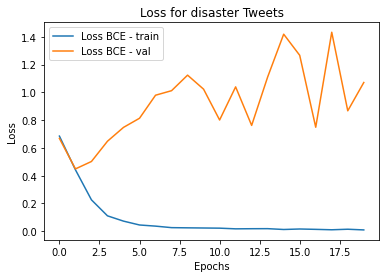

In [ ]:
# Plot history: Binary Cross-entropy
plt.plot(history.history['loss'], label='Loss BCE - train')
plt.plot(history.history['val_loss'], label='Loss BCE - val')
plt.title('Loss for disaster Tweets')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper left")

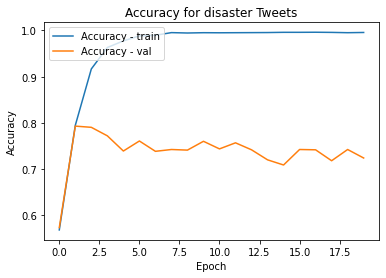

In [ ]:
# Plot history: Accuracy
plt.plot(history.history['binary_accuracy'], label='Accuracy - train')
plt.plot(history.history['val_binary_accuracy'], label='Accuracy - val')
plt.title('Accuracy for disaster Tweets')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")

# VI. Metrics & Results on test 

In [ ]:
test_tweet = test_df.loc[:, test_df.columns =='text'].values.flatten()

In [ ]:
results = {'text':test_tweet, 'target': (list(map((lambda x : 1 if x >0.5 else 0), model.predict(test_pad))))}
df_results = pd.DataFrame(results)
df_results

,text,target
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...
3246,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3247,Storm in RI worse than last hurricane. My city...,1
3248,Green Line derailment in Chicago http://t.co/U...,1
3249,MEG issues Hazardous Weather Outlook (HWO) htt...,1


## VII. Analysis

In [ ]:

#Let's take time to push the analysis and think about what you could do to improve this algorithm.